# Twitter flash crash 

In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import pandas as pd
from sklearn import preprocessing

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGaussian, GaussianUnknownMeanVariance
from omega_estimator import OmegaEstimatorGaussian
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import data

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/Flashcrash')
FILE_PATH = os.path.join(DATA_PATH,'Flashcrash/DJI.txt')

In [3]:
DJI = pd.read_csv(FILE_PATH, header = None)
DJI.columns =['date', 'open', 'high', 'low', 'close']
DJI['date'] = pd.to_datetime(DJI['date'], infer_datetime_format=True)
flash_crash_dji = DJI[(DJI['date'].dt.date.astype(str) == '2013-04-23')]

In [4]:
data = flash_crash_dji['open'].values
dates = flash_crash_dji['date'].values

In [5]:
T=len(data)
data = data.reshape([T,1])

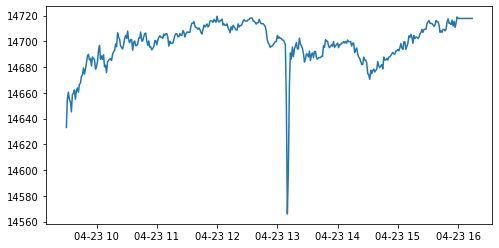

In [6]:
plt.subplots(figsize=(8,4))
plt.plot(dates,data)

In [7]:
data_scaled = preprocessing.StandardScaler().fit_transform(data)

## Define functions needed for the method: $m$, $\nabla m$ , $\nabla r$, $\nabla b$ , $\nabla^2 r$

In [8]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_r(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_r(x):
    return np.asarray([[[0,-1]]])

## Prior parameters

In [9]:
mean_mu0 = 0
var_mu0 = 1

mean_Sigma0 = 10
var_Sigma0 = 1

mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

Sigma0 = np.eye(2)
Sigma0[0,0] = mean_Sigma0/var_Sigma0
Sigma0[1,1] = 1/var_Sigma0

## Initialize estimator to find $\omega$

In [10]:
estimator = OmegaEstimatorGaussian(data_scaled[100:200], m ,grad_m, grad_r, hess_r, grad_b, mu0, Sigma0)

In [11]:
omegas, costs = estimator.omega(0.1, lr = 1e-11, niter = 2000, prior_parameters= [1, 1, 100, 100])

In [12]:
omega = omegas[-1]
print(omega)

0.0005270852125249803


## Initialize models and CP prior

In [13]:
model_DSM = DSMGaussian(data_scaled, m ,grad_m, grad_r, hess_r, grad_b, np.round(omega,5), mu0, Sigma0, b = 20)
model_standard  = GaussianUnknownMeanVariance(0, 1, 2, 10)

In [14]:
hazard = ConstantHazard(300)

## Run BOCD algorithm

In [15]:
%%time
np.random.seed(100)
R_DSM  = bocpd(data_scaled, hazard, model_DSM, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
CPU times: user 37.2 s, sys: 8.76 ms, total: 37.2 s
Wall time: 37.3 s


In [16]:
%%time
R_standard  = bocpd(data_scaled, hazard, model_standard)

CPU times: user 110 ms, sys: 3 µs, total: 110 ms
Wall time: 110 ms


## Plot

/tmp/ipykernel_6634/1865482055.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


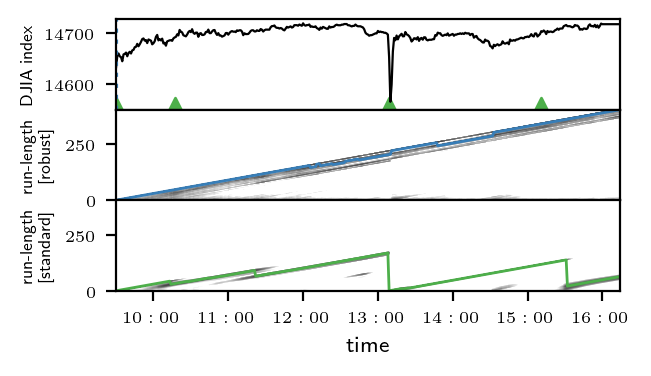

In [20]:
FILE_NAME = 'Flashcrash.pdf'
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

cps_DSM = find_cp(R_DSM)
cps_standard= find_cp(R_standard)

x_lims = mdates.date2num([dates[0],dates[-1]])
with plt.rc_context(bundles.icml2022(ncols=2)):

    fig, ax = plt.subplots(3, 1, sharex = True , gridspec_kw={'height_ratios': [1,1,1]}, dpi = 200, figsize= (3.25, 1.8))
    ax[0].plot(dates, data[:,0],c='black',lw=0.8)
    y_lims = ax[0].get_ylim()
    ax[0].set_xlim([x_lims[0],x_lims[1]])
    
    ax[1].set_ylim([0,T])
    ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T], interpolation=None)
    ax[1].plot(dates,np.argmax(R_DSM[1:],axis=1), c=CB_color_cycle[0], alpha=1, lw=1)
    
    ax[2].set_ylim([0,T])
    ax[2].imshow(np.rot90(R_standard), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[2].plot(dates,np.argmax(R_standard[1:],axis=1), c=CB_color_cycle[2], alpha=1, lw=1)

    for cp in cps_DSM:
        ax[0].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        
    for cp in cps_standard:
        ax[0].scatter(dates[cp], y_lims[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
        
    ax[0].xaxis.set_major_locator(mdates.HourLocator())
    date_form = DateFormatter("%H:%M")
    ax[1].xaxis.set_major_formatter(date_form)
    
    ax[2].set_ylabel('run-length \n [standard]' , size = 6)
    ax[1].set_ylabel('run-length \n [robust]' , size = 6)
    ax[0].set_ylabel('DJIA index', size= 6)
    
    ax[2].set_xlabel('time')
    
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

In [21]:
bundles.icml2022(ncols=2)

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 1.0043052317185792),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

/tmp/ipykernel_6634/1239987105.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


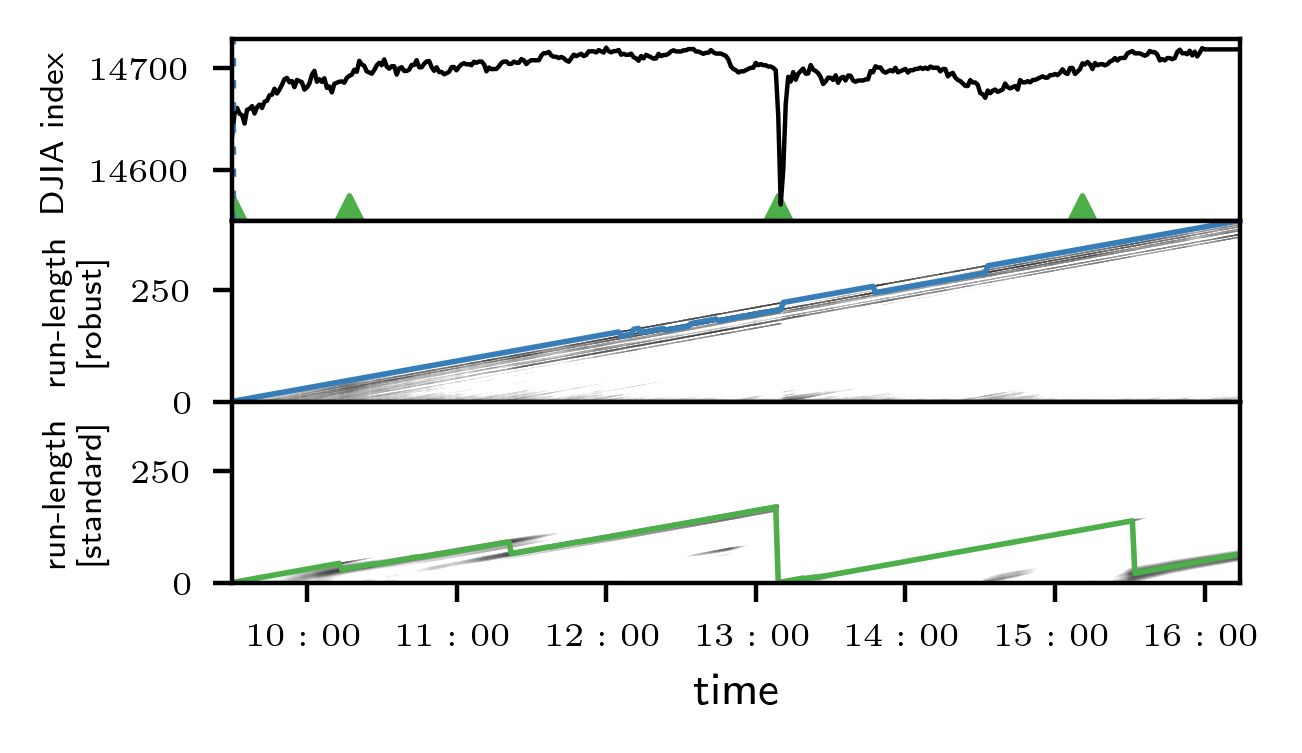

In [24]:
FILE_NAME = 'Flashcrash.pdf'
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

cps_DSM = find_cp(R_DSM)
cps_standard= find_cp(R_standard)

x_lims = mdates.date2num([dates[0],dates[-1]])
with plt.rc_context(bundles.icml2022(ncols=2)):

    fig, ax = plt.subplots(3, 1, sharex = True , gridspec_kw={'height_ratios': [1,1,1]}, dpi = 400, figsize= (3.25, 1.8))
    ax[0].plot(dates, data[:,0],c='black',lw=0.8)
    y_lims = ax[0].get_ylim()
    ax[0].set_xlim([x_lims[0],x_lims[1]])
    
    ax[1].set_ylim([0,T])
    ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[1].plot(dates,np.argmax(R_DSM[1:],axis=1), c=CB_color_cycle[0], alpha=1, lw=1)
    
    ax[2].set_ylim([0,T])
    ax[2].imshow(np.rot90(R_standard), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[2].plot(dates,np.argmax(R_standard[1:],axis=1), c=CB_color_cycle[2], alpha=1, lw=1)

    for cp in cps_DSM:
        ax[0].axvline(dates[cp], c=CB_color_cycle[0], ls='dotted', lw=1.5)
        
    for cp in cps_standard:
        ax[0].scatter(dates[cp], y_lims[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
        
    ax[0].xaxis.set_major_locator(mdates.HourLocator())
    date_form = DateFormatter("%H:%M")
    ax[1].xaxis.set_major_formatter(date_form)
    
    ax[2].set_ylabel('run-length \n [standard]' , size = 6, fontweight='bold')
    ax[1].set_ylabel('run-length \n [robust]' , size = 6, fontweight='bold')
    ax[0].set_ylabel('DJIA index', size= 6, fontweight='bold')
    
    ax[2].set_xlabel('time', fontweight='bold')
    
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")